# Classifying Company Descriptions
Convert text to vectors using Sentence-Transformers and classify with Scikit-learn's NearestCentroid model.

In [4]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read in the data from the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CultivAIte_Code/crunchbase-company-descriptions-dataset.csv')
df = df[df['desc'].notna()] # delete rows without a description
df

,Unnamed: 0,permalink,name,desc,category_code
0,0,sti-technologies,STI Technologies,STI Technologies is a mechanical engineering c...,software
1,1,jumio,Jumio,Jumio is an AI platform that enables users to ...,software
2,2,roundpegg,RoundPegg,RoundPegg is a culture and engagement platform...,software
3,3,personeta,Personeta,Personeta provides converged communication sol...,software
4,4,hubspan,Hubspan,Hubspan offers on-demand integration services ...,software
...,...,...,...,...,...
10292,10292,army-air-force-exchange-service,Army & Air Force Exchange Service,"For more than 115 years, the Exchange's missio...",government
10293,10293,best-apps-market,Best Apps Market,Best Apps Market is an app and game recommenda...,government
10295,10295,human-genome-research-institutes,Human Genome Research Institutes,Human Genome Research Institute researches in ...,government
10296,10296,icount-com,Icount.com,Icount is a political website that empowers th...,government


Note that the descriptions are short - usually less than 20 words:

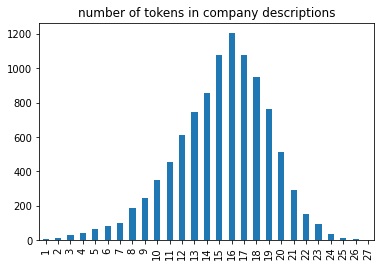

In [8]:
lengths = df['desc'].apply(lambda x: len(x.split(' ')))
lengths.value_counts().sort_index().plot(kind='bar', title='number of tokens in company descriptions')

In [9]:
# remove classes that have less instances than some threshold (aka 'government' class has only 5, not enough for train/test split.)
threshold = 5
col = 'category_code'
counts = df[col].value_counts()
df = df.loc[df[col].isin(counts[counts > threshold].index), :]
df[col].value_counts()

biotech             492
hardware            489
cleantech           487
enterprise          487
advertising         485
games_video         485
web                 484
medical             483
software            479
ecommerce           479
mobile              473
analytics           432
health              390
network_hosting     314
other               296
finance             288
education           282
social              266
security            256
semiconductor       253
public_relations    205
manufacturing       176
consulting          173
search              157
hospitality         132
messaging           132
news                102
fashion              97
travel               83
music                82
photo_video          76
real_estate          75
nonprofit            68
sports               67
automotive           47
transportation       41
legal                41
nanotech             36
design               19
local                16
pets                 14
Name: category_c

In [10]:
# download embedding model
from sentence_transformers import SentenceTransformer

# Sentence Transformer model options ranked: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-MiniLM-L12-v2') # sbert.net for more models
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [11]:
# make embedding vectors for each company's description text
embeddings = model.encode(df['desc'].to_numpy())
embeddings.shape

(9939, 384)

In [12]:
# Split the dataset into train/val/test split
from sklearn.model_selection import train_test_split

# Split dataset 80/20 for training/testing -- use 'stratify' to guarantee class representation in each set
category_labels = df['category_code']
X_train, X_test, y_train, y_test = train_test_split(embeddings, category_labels, test_size=0.2, random_state=0, stratify=category_labels)

### Logistic Regression (Decent)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds)) # 0.42 F1 score out of the box?

                  precision    recall  f1-score   support

     advertising       0.44      0.58      0.50       145
       analytics       0.40      0.50      0.45       130
      automotive       0.50      0.07      0.12        14
         biotech       0.66      0.66      0.66       148
       cleantech       0.66      0.83      0.74       146
      consulting       0.41      0.13      0.20        52
          design       0.00      0.00      0.00         6
       ecommerce       0.36      0.51      0.42       144
       education       0.68      0.79      0.73        85
      enterprise       0.25      0.25      0.25       146
         fashion       0.62      0.28      0.38        29
         finance       0.51      0.56      0.53        86
     games_video       0.49      0.62      0.55       145
        hardware       0.25      0.29      0.27       147
          health       0.47      0.56      0.51       117
     hospitality       0.45      0.42      0.44        40
           le

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Logistic Regression requires two parameters 'C' and 'penalty' to be optimised by GridSearchCV.
C = np.logspace(-4, 4, 50)
penalty = ['l2']

parameters = {"C":C, "penalty":penalty}

clf = GridSearchCV(LogisticRegression(), parameters)
clf.fit(X_train, y_train)
print(np.max(clf.cv_results_['mean_test_score']))
clf.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.44242967930125515


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 1.2067926406393288, 'penalty': 'l2'}

### LazyPredict (try a variety of models all at once)

In [ ]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test) # this took 23 minutes :/

In [ ]:
print('\n'+models)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.42               0.48    None      0.41   
LinearDiscriminantAnalysis         0.44               0.48    None      0.43   
GaussianNB                         0.43               0.45    None      0.42   
BernoulliNB                        0.41               0.44    None      0.40   
RidgeClassifier                    0.43               0.36    None      0.39   
RidgeClassifierCV                  0.43               0.36    None      0.39   
SVC                                0.43               0.35    None      0.41   
LinearSVC                          0.32               0.31    None      0.31   
PassiveAggressiveClassifier        0.31               0.30    None      0.31   
LogisticRegression                 0.33               0.29    None      0.32   
XGBClassifier                      0.38 

### Nearest Centroid

In [13]:
# NearestCentroid model gets F1 of 0.41, but defaults to euclidean. maybe try cosine?
# SVC had F1 of 0.41, Perceptron had 0.31, random forest had 0.28. maybe these have more tuneable parameters?

from sklearn.neighbors import NearestCentroid
clf = NearestCentroid(metric='cosine')
clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


NearestCentroid(metric='cosine')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

preds = clf.predict(X_test)
print(f'Overall Accuracy: {accuracy_score(y_test, preds)}')
print(classification_report(y_test, preds))

Overall Accuracy: 0.42354124748490946
                  precision    recall  f1-score   support

     advertising       0.53      0.42      0.47        97
       analytics       0.51      0.45      0.48        86
      automotive       0.28      0.78      0.41         9
         biotech       0.68      0.64      0.66        99
       cleantech       0.79      0.69      0.74        98
      consulting       0.22      0.31      0.26        35
          design       0.12      0.50      0.19         4
       ecommerce       0.50      0.32      0.39        96
       education       0.74      0.82      0.78        56
      enterprise       0.36      0.21      0.27        98
         fashion       0.48      0.79      0.60        19
         finance       0.55      0.52      0.53        58
     games_video       0.69      0.47      0.56        97
        hardware       0.23      0.12      0.16        98
          health       0.44      0.58      0.50        78
     hospitality       0.48      

Check the top-k accuracy; it often gets the right answer in the top few results.

In [52]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import pairwise_distances

# new method that returns the probabilities/logist/distances for each class, instead of just returning the one predicted class
def nearest_centroids_predict_proba(clf, X):
  return -1*pairwise_distances(X, clf.centroids_) # remember, these are distances, so reverse it so the max value is the closest.

prob_preds = nearest_centroids_predict_proba(clf, X_test)

# convert y_test into int indexes
int_to_label = dict(enumerate(clf.classes_))
label_to_int = {v: k for k, v in int_to_label.items()}
y_test_indexes = y_test.apply(lambda label_str: label_to_int[label_str]).to_numpy()

print('Top-K Accuracy:')
for i in range(1,11):
  top_k_acc = top_k_accuracy_score(y_test_indexes, prob_preds, k=i)
  print(f'Top {i}: {top_k_acc:.2f}')

Top-K Accuracy:
Top 1: 0.42
Top 2: 0.58
Top 3: 0.68
Top 4: 0.74
Top 5: 0.80
Top 6: 0.83
Top 7: 0.85
Top 8: 0.88
Top 9: 0.89
Top 10: 0.90


### Analysis: Why only 42% accuracy score?
* Since there are 41 classes, the baseline for random guessing is 2.4% accuracy. Guessing the majority class in the test set results in 4.9% accuracy. Compared to these baselines, 42% indicates a relatively strong classifier.  
  
* Most companies fall under several categories - a company that makes, for example, fitness tracking devices for dogs, could be labeled as `pets`, `software`, `hardware`, `health`, and so on. However, in the data, each company is labeled with *only one category*. 
* Furthermore, many categories seem to have serious overlap; for example, `web`/`software`/`mobile`/`social`/`search` all relate to apps and software, along with many other examples. 
* Finally, the presence of meaningless and miscellaneous categories such as `local` and `other` add noise and bring down the overall score.
  
* Category ambiguity is the likely cause of the low accuracy, as evidenced by the fact that the top-k accuracy dramatically increases when looking at just the top few predicted classes.

In [57]:
#@title Classify Custom Input Text

input_text = 'an app that calculates optimal fantasy football stats' #@param {type:"string"}
print('INPUT:', input_text)

input_embedding = model.encode([input_text])
preds = nearest_centroids_predict_proba(clf, input_embedding)

print("OUTPUT:")
output = list( zip(clf.classes_, preds[0]) )
output.sort(key = lambda x: x[1], reverse=True)
output[:3] # just look at the top 3

INPUT: an app that calculates optimal fantasy football stats
OUTPUT:


[('sports', -0.8054162848477883),
 ('analytics', -0.9051345528048182),
 ('games_video', -0.9190240584286031)]